In [13]:
#################################### IMPORTS ###################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import datetime
from keras.backend.tensorflow_backend import set_session

In [14]:
##################### INICIALIZACAO DE VARIAVEIS ################################################
index_arquivo = ['preco', 'hr_int', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'] #index do arquivo
steps = [] # 9h04 -> 17h50 a cada 5 segundos 
epocas = 10000 #quantidade de vezes que vai rodar todos os dias
janela = 10 #janela de valores
n_variaveis = len(index_arquivo) #'preco', 'hr_int', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'
n_entradas = n_variaveis * janela + 3 #ncont, valor, posicao e inputs
n_neuronios = 216 #numero de neuronios da camada escondida
n_saidas = 3 #nmero de saidas da rede (compra, vende, segura)
custo = 1.06/2 #custo da operao
melhor_reward = 0
posicao_max = 50 #define variavel para normalizar a posicao
lim_cont = 1

versao_arquivo = 1

carregar_pesos = True
carregar_epoca_epsilon = False
epoca_init = 0
if carregar_epoca_epsilon:
    file = open("./epoca_epsilon.txt", "r")
    valores = file.read().split(',')
    epoca_init = int(valores[0])
    epsilon = float(valores[1])
    file.close()
else:
    epsilon = 1.0 #valor de epsilon
epsilon_min = 0.01 #valor minimo de epsilon
epsilon_decay = (epsilon - epsilon_min) / (epocas - epoca_init) #o valor que vai retirado do epsilon por epoca

rewards = [0] #variavel para guardar rewards
plotx = [0] #variavel para guardar valores a serem plotados do eixo x

In [15]:
####################### LEITURA DOS DADOS #######################################################
caminho_arquivo = ('./consolidado.csv')
arquivo = pd.read_csv(caminho_arquivo) #le arquivo
inputs = arquivo[index_arquivo]
if versao_arquivo == 1: #se quiser usar apenas os dias com IND e ISP
    inputs = inputs[inputs['IND'] != 0]
    arquivo = arquivo[arquivo['IND'] != 0]
pmax = np.amax( inputs.loc[:, inputs.columns[0]] ) #define valor minimo do preo
pmin = np.amin( inputs.loc[:, inputs.columns[0]] ) #define valor maximo do preo

for i in range( inputs.shape[1] ): #roda normalizo para todas as colunas
    imax = np.amax( inputs.loc[:, inputs.columns[i]] ) #pega valor maximo
    imin = np.amin( inputs.loc[:, inputs.columns[i]] ) #pega valor minimo
    inputs.loc[:, inputs.columns[i]] = ( inputs.loc[:, inputs.columns[i]] - imin ) / ( imax - imin ) #normaliza prs

dt = arquivo['dt'].values #cria coluna apenas dos dias
hr = arquivo['hr_int']/1000
steps = []
ultimo_dia = 0
dias_para_rodar = [] #variavel para colocar os dias a serem rodados
j = 0
for i in range( 0, len(dt) ):
    if (dt[i] != ultimo_dia):
        steps.append(i) #numero de linhas entre dias
        ultimo_dia = dt[i]
        dias_para_rodar.append(j) #numero do dia
        j += 1
dias = len(steps)
dias = 100

In [16]:
########################################   BIBLIOTECAS ####################################
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K            #importa backend para clear_session()

##################### MODELO DQN ####################################################
class DQNAgent:
    ########################### INICIALIZA ###########################################
    def __init__(self, state_size, action_size, epsilon, janela, n_neuronios, n_variaveis):
        self.state_size = state_size
        self.n_neuronios = n_neuronios
        self.action_size = action_size
        self.janela = janela
        self.n_variaveis = n_variaveis
        self.limpa_memoria()
        self.gamma = 0.99       # discount rate
        self.epsilon = epsilon  # exploration rate
        self.learning_rate = 1e-10
        self.model = self.cria_modelo()
        self.model.summary()

################################# REDE NEURAL ###########################################
    def cria_modelo(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        """
        model.add(Dense(self.n_neuronios, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='softmax')) #camada de saida
        model.compile(loss='categorical_crossentropy', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        """
        
        model.add(Dense(128, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(64, activation='relu')) #camada escondida
        model.add(Dense(32, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='softmax')) #camada de saida
        model.compile(loss='categorical_crossentropy', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        
        
        return model

    def limpa_memoria(self):
        self.state = np.empty((0,))
        self.next_state = np.empty((0,))
        
    def toma_acao(self, valores_ant, teste):
        if not teste and np.random.rand() <= self.epsilon: #se o numero aleatorio for menor que o epsilon
            return random.randrange(self.action_size) #retorna acao aleatoria
        estado = np.array([np.append(self.state, valores_ant)]) #cria valor de agora        
        act_values = self.model.predict(estado, batch_size=1) #calcula qual a melhor acao
        return np.argmax(act_values[0])  # returns action

    def treina_modelo(self, acao, reward, valores_ant, valores_dps, batch_size=1):
        prox_estado = np.array([np.append(self.next_state, valores_dps)]) #cria proximo estado
        target = (reward + self.gamma * np.amax(self.model.predict(prox_estado, batch_size=batch_size)[0])) #pega valor que quer chegar
        
        estado = np.array([np.append(self.state, valores_ant)]) #cria valor de agora
        target_f = self.model.predict(estado, batch_size=batch_size) #pega valor que chegou
        target_f[0][acao] = target #define o valor que deseja chegar
        
        self.model.fit(estado, target_f, epochs=1, verbose=0, batch_size=batch_size) #treina modelo
        
    def tira_ultimo_state(self):
        if self.state.shape[0] > self.janela * self.n_variaveis:
            self.state = self.state[self.n_variaveis:] #tira os ultimos preos
        if self.next_state.shape[0] > self.janela * self.n_variaveis:
            self.next_state = self.next_state[self.n_variaveis:] #tira os ultimos preos
        
    def carrega_pesos(self, name):
        self.model.load_weights(name) #carrega pesos

    def salva_pesos(self, name):
        self.model.save_weights(name) #salva pesos
        
########################  DECLARA MODELO ################################
modelo = DQNAgent(n_entradas, n_saidas, epsilon, janela, n_neuronios, n_variaveis)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               10752     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 99        
Total params: 21,187
Trainable params: 21,187
Non-trainable params: 0
_________________________________________________________________


In [17]:
########################### FUNCOES ###############################################################

def atuacao( preco, ncont, acao, custo, valor ):  #preco atual, n de contratos posicionados,
                                                #acao atual, custo, valor da posio
    valor_cheio = 0.
    ncont_anterior = ncont #salva posicao anterior
    ncont += acao #posicao atual = pos anterior + acao
    
    if valor != 0:
        valor_cheio = ( valor * ( pmax - pmin ) + pmin )  #valor posicionado atual

    dp = ( preco * ( pmax - pmin ) + pmin ) - valor_cheio #variao do preo atual e do preo de compra/venda
    posicao = ncont_anterior * dp * 10 - custo * abs(acao) #posicao = lucro - custo (INSTANTNEO)

    #calculos sobre o valor    
    if ( ncont_anterior == 0 and acao != 0 ): #primeiro valor
        valor = preco
    elif ( ncont == 0 ):
        valor = 0
    #caso nao se encaixe nessas condies: valor = valor (nada muda)

    return ncont, valor, posicao, ncont_anterior

def obter_acao(ncont, valores_ant):
    decisao = modelo.toma_acao(valores_ant, False) #calcula a saida da rede neural
    
    if decisao == 0: #comprar
        if ncont <= lim_cont: #s compra se no tem nada ainda
            return 1
    elif decisao == 1: #vender
        if ncont >= -lim_cont: #só vende se tiver alguma coisa
            return -1
    return 0 #neutro

def rodar_1dia(precos, custo, dia):
    global melhor_reward
    ncont = 0 #cria variavel de quantidade de contratos
    ncont_anterior = 0 #cria variavel para quantidade de contratos anterior
    valor = 0 #cria variavel para preo medio
    reward = 0 #cria variavel para recompensa
    posicao = 0 #cria variavel de posio 
    modelo.limpa_memoria() #limpa o vetor de memoria
    
    for step in range( steps[dia - 1], steps[dia] ):  #roda os dados
        
        ultimos_precos = precos[ step : step + 1 ] #pega os valores de agora
        modelo.state = np.append( modelo.state, ultimos_precos ) #adiciona na variavel de estado
        
        modelo.tira_ultimo_state()
        valores_ant = [ncont, valor, posicao / posicao_max] #grava os valores de antes

        if modelo.state.shape[0] == janela * n_variaveis: #se ja tem memoria suficiente
            acao = obter_acao( ncont, valores_ant ) #obtem ao
            ncont, valor, posicao, ncont_anterior = atuacao(precos['preco'][step], ncont, acao, custo, valor)
            if ( ncont_anterior != ncont ): #reward acumulado recebe reward instantaneo somente se houver lucro/prejuizo real   
                reward += posicao #soma reward
                #print("acao: {0} reward: {1} hora: {2}".format(acao, reward, str(datetime.timedelta(seconds=hr[step]))))
            
        prox_precos = precos[ step + 1 : step + 2 ] #pega os proximos valores
        modelo.next_state = np.append(modelo.next_state, prox_precos) #adiciona variavel na variavel de proximo estado
        modelo.tira_ultimo_state()
        valores_dps = [ncont, valor, posicao / posicao_max] #grava os valores de depois
        
        if modelo.state.shape[0] == janela * n_variaveis: #se ja tem memoria suficiente
            modelo.treina_modelo(acao, posicao / posicao_max, valores_ant, valores_dps) #roda o modelo
            
    reward += posicao - custo * abs(ncont) #soma reward - DAY-TRADE (obs: custo nao havia sido considerado no reward pq acao era 0)
    if reward > melhor_reward:
        melhor_reward = reward
    return reward #retorna o valor do reward

dias_pos = 0
dias_neg = 0

def rodar_dias(precos, custo):   
    global dias_pos
    global dias_neg
    sum_rewards = 0 #cria variavel de somatoria de recompensas
    for dia in range( 1, dias ): #loop de dias
        reward = rodar_1dia(precos, custo, dia)
        sum_rewards += reward #roda 1 dia e adiciona o total na variavel de somatoria
        #print("dia {0} de {1}: R$ {2:0.2f}".format(dia, dias, reward)) #mostra o resultado do dia
        if reward>0: 
            dias_pos += 1
        elif reward<0:
            dias_neg += 1
    return sum_rewards


resultado da epoca 0 = 7523.77
resultado da epoca 1 = 5658.54
resultado da epoca 2 = 7596.44
resultado da epoca 3 = 1258.93
resultado da epoca 4 = 9174.99
resultado da epoca 5 = -1718.19
resultado da epoca 6 = 1701.51
resultado da epoca 7 = 11947.20
resultado da epoca 8 = 14933.93
resultado da epoca 9 = 14779.46
resultado da epoca 10 = 20492.34
resultado da epoca 11 = 10297.50
resultado da epoca 12 = 9542.57
resultado da epoca 13 = 15766.05
resultado da epoca 14 = 15202.11
resultado da epoca 15 = -2088.42
resultado da epoca 16 = -3516.53
resultado da epoca 17 = 7495.61
resultado da epoca 18 = 9076.97
resultado da epoca 19 = 4289.16
resultado da epoca 20 = 11635.91
resultado da epoca 21 = -4768.65
resultado da epoca 22 = 3145.06
resultado da epoca 23 = 2632.41
resultado da epoca 24 = -9056.60
resultado da epoca 25 = 14224.39
resultado da epoca 26 = -704.78
resultado da epoca 27 = -2196.30
resultado da epoca 28 = -4206.90
resultado da epoca 29 = 1179.99
resultado da epoca 30 = 18500.52
r

KeyboardInterrupt: 

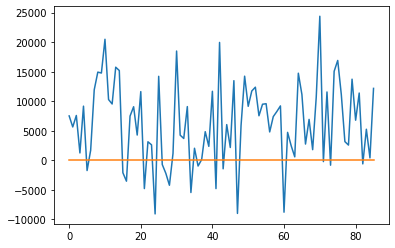

In [18]:
import time
##################################  MAIN  #########################################
if __name__ == "__main__":
    global dias_pos
    global dias_neg
    sum_rewards_total = 0
    modelo.epsilon = 0.03
    sr=[]
    try:
        if carregar_pesos:
            modelo.carrega_pesos('./pesos.h5')
        epoca_parou = epoca_init
        for epoca in range(epoca_init, epocas): #rodar uma quantidade de epocas
            #s=time.time()
            #print("epoca {0}\n".format(epoca)) #mostra que epoca vai rodar
            sum_rewards = rodar_dias(inputs, custo) #adiciona o resultado da epoca na somatoria
            sum_rewards_total += sum_rewards
            sr.append(sum_rewards)
            print("resultado da epoca {0} = {1:0.2f}".format(epoca, sum_rewards))
            epoca_parou += 1
            if ((epoca % 200) == 0):
                modelo.salva_pesos('./pesos.h5')
            #e=time.time()
            #print(e-s)
            #modelo.epsilon -= epsilon_decay
    finally:
        print(dias_pos)
        print(dias_neg)
        modelo.salva_pesos('./pesos.h5')
        if carregar_epoca_epsilon:
            file = open("./epoca_epsilon.txt", "w")
            file.writelines("{0},{1}".format(epoca_parou, modelo.epsilon))
            file.close()
            print("parou na epoca {0} com epsilon {1}".format(epoca_parou, modelo.epsilon))
        print("Somatoria dos rewards: {0:0.2f}".format(sum_rewards_total))
        print("Melhor resultado diario: {0:0.2f}".format(melhor_reward))
        plt.plot(range(0, len(sr)), sr, range(0, len(sr)), np.zeros(len(sr))) #plota os valores de reward por epoca